In [1]:
%load_ext autoreload
%autoreload 2

import time

import mujoco as mj
import mujoco.viewer
import mujoco.renderer # Additional import

import numpy as np
from scipy.spatial.transform import Rotation as R

from utility import unit
from controller import Controller
from human import Human

from sensors import Sensors
from video_recorder import Recorder

def move_simple(name, *, t, func, axis=-1, model):
  model.site(name).pos[axis] = func(t)

m = mj.MjModel.from_xml_path('./mjcf/tec.xml')
d = mj.MjData(m)
t = 0

# Create a renderer for data collection
r_rgb = mujoco.renderer.Renderer(m, 480, 640)
r_depth = mujoco.renderer.Renderer(m, 480, 640)
r_seg = mujoco.renderer.Renderer(m, 480, 640)
r_depth.enable_depth_rendering()
r_seg.enable_segmentation_rendering()

# Create a recorder for data collection
sensor = Sensors()
recorder = Recorder(duration=30, 
                    fps=30, 
                    n_cameras=m.cam_user.shape[0], 
                    folder="./")

mujoco.mj_step(m, d)

In [2]:
with mujoco.viewer.launch_passive(m, d) as viewer:
# Close the viewer automatically after 30 wall-seconds.

    start = time.time()
    while viewer.is_running() and time.time():
        step_start = time.time()

        # policy
        # mj_step can be replaced with code that also evaluates
        # a policy and applies a contro l signal before stepping the physics.
        mujoco.mj_step(m, d)
        t += 0.1

        # Get RGB, depth, and segmentation images
        readings = sensor.get_rgbd_seg_matrices(m, d, r_rgb, r_depth, r_seg)
        # # Save images to recorder
        # recorder.add_frame(readings)

        # Pick up changes to the physics state, apply perturbations, update options from GUI.
        viewer.sync()

        # Rudimentary time keeping, will drift relative to wall clock.
        time_until_next_step = m.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)
            time.sleep(0.01)

# Save videos
# recorder.show_videos()

""

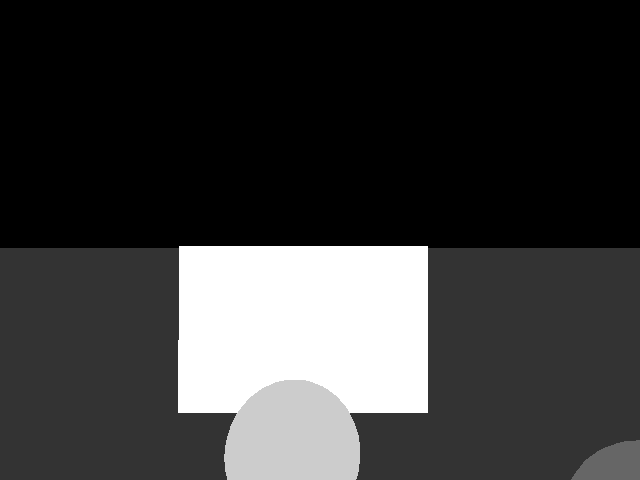

""

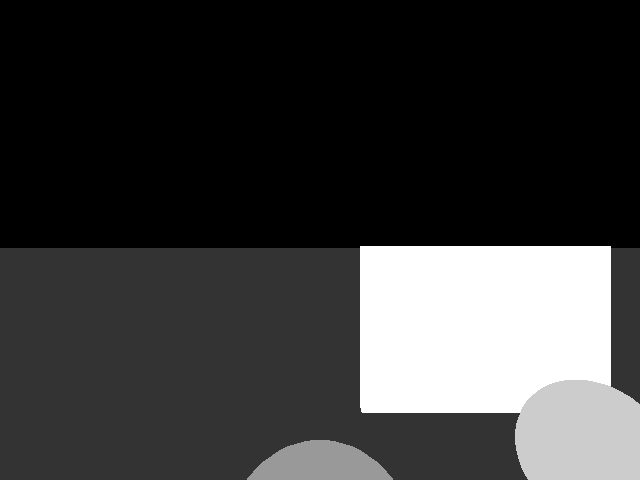

""

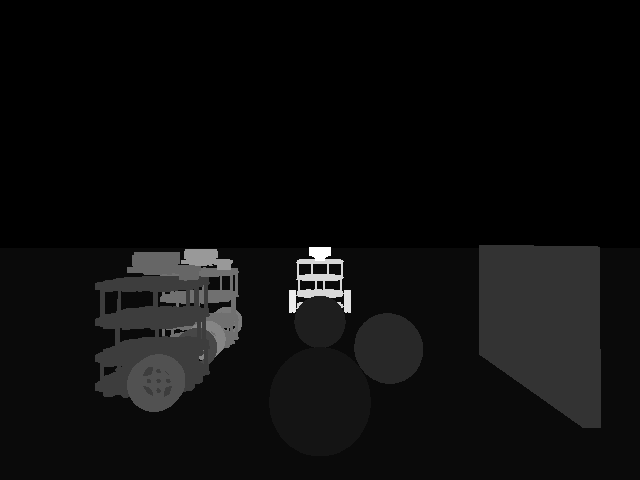

In [4]:
import mediapy as media

# show rgb
media.show_image(readings[0][:, :, 4])

# show depth
media.show_image(readings[1][:, :, 4])

# show seg
media.show_image(readings[2][:, :, 4])

## Point Cloud Retrieve
Code fragment of how to retrieve the point clouds.

In [14]:
import open3d as o3d

def draw_pc(pc):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.vstack((pc, np.array([0.2,0.2,0.2]))))
    o3d.visualization.draw_plotly([pcd])

def show_pc(pc, colors=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc)
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])

def transform_point_cloud(pc_array):
    pc_array = pc_array - np.mean(pc_array, axis=0)
    pc_array = pc_array[np.random.choice(pc_array.shape[0], 512, replace=True), :]
    # pc_array = pc_array / np.max(np.linalg.norm(np.abs(pc_array), axis=1))
    return pc_array

In [20]:
from vectorized_point_cloud import VectorizedPC
point_cloud = VectorizedPC((480, 640), 60)

# Get RGB, depth, and segmentation images
depth = [*sensor.get_depth_image_matrices(m, d, r_depth).values()]
segmn = [*sensor.get_segment_image_matrices(m, d, r_seg).values()]

cam_num = m.cam_user.shape[0]
cam_pos = []
cam_rot = []
for i in range(cam_num):
    cam_pos.append(m.cam_pos[i])
    cam_rot.append(R.from_quat(m.cam(i).quat).as_matrix())

# Obtaining the pointclouds from the depth images segmented
pc = {}
mat = None
for i in range(cam_num):
    rot = (R.from_matrix(cam_rot[i]).as_euler('xyz', degrees=True)[0] - 180) * -1
    rot = R.from_euler('xyz', [rot, 0, 90], degrees=True).as_matrix()
    aux = point_cloud.get_segmented_points(depth[i],
                                        segmn[i],
                                        rot,
                                        cam_pos[i])
    for key in aux.keys():
        if mat is None:
            mat = aux[key]
        else:
            mat = np.concatenate((mat, aux[key]))

    show_pc(mat)

    
    # for key in aux.keys():
    #     if key == -1:
    #         continue
    #     try:
    #         pc[key] = np.concatenate((pc[key], aux[key]))
    #     except:
    #         pc[key] = aux[key]

In [18]:
show_pc(aux)

RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

In [17]:
for i in list(pc.keys()):
    pc_array = transform_point_cloud(pc[i])
    show_pc(pc[i])

In [5]:
# Retrieve data from the cameras
readings = sensor.get_rgbd_seg_matrices(m, d, r_rgb, r_depth, r_seg)
frames = [readings[i][:, :, 3] for i in range(len(readings))]
segments = [readings[i][:, :, 4] for i in range(len(readings))]

# This can be obtained from the model at the beginning of the simulation
# Or thery can be retrieved at any time during the simulation
# Get the position and rotation of the cameras
poses = []
rotations = []
for i in range(m.cam_user.shape[0]):
    # Get the position of the camera
    pos = m.cam_pos[i] + m.body(m.cam_bodyid[i]).pos
    poses.append(pos)

    # Get the rotation of the camera
    angle = R.from_quat(m.body(m.cam_bodyid[i]).quat).as_euler('xyz', degrees=True)
    rotations.append(angle[0])



# Generate point cloud from depth image
import point_cloud as pcu

point_cloud = pcu.PointCloud((480, 640), 60, downsample=2)

mat = point_cloud.get_map(frames, poses, rotations)

segemented_mat = point_cloud.get_segmented_map(frames, segments, poses, rotations, m)

feature_vectors = point_cloud.get_feature_vectors(segmented_map=segemented_mat)

# Save point cloud
# np.save("point_cloud.npy", mat)

In [ ]:
feature_vectors

In [ ]:
size = 0
for key in segemented_mat:
    size += len(segemented_mat[key])

print("Total -> ", mat.shape)
print("Segmented -> ", size)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Define the x, y, z coordinates of the point cloud
x = mat[:, 0]
y = mat[:, 1]
z = mat[:, 2]

# Plot the point cloud data
ax.scatter(x, y, z, s=1)

# Set the axis labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


for key in segemented_mat.keys():
    mat = np.array(segemented_mat[key])
    print(mat.shape)

    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.suptitle(key)

    # Define the x, y, z coordinates of the point cloud
    x = mat[:, 0]
    y = mat[:, 1]
    z = mat[:, 2]

    # Plot the point cloud data
    ax.scatter(x, y, z, s=1)

    # Set the axis labels
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Show the plot
    plt.show()

## Generation of the Dataset

In [ ]:
import torch
import pandas as pd
from torch_geometric.data import Data
import numpy as np


# Reading from the dataset csv
dataset = pd.read_csv('dataset.csv')
dataset.head()


# Creating the dataset class
class MyDataset(Data):
    def __init__(self, x, edge_index, y):
        super(MyDataset, self).__init__()
        self.x = x
        self.edge_index = edge_index
        self.y = y


#  Creating data for the dataset
V = np.array(dataset.iloc[:, 2:], dtype='float32')

labels = np.array(dataset.iloc[:, 1])
for i in range(len(labels)):
    if "human" in labels[i]:
        labels[i] = 1
    elif "robot" in labels[i]:
        labels[i] = 0

labels = np.array(labels, dtype='int8')
def get_edge_index(V):
    edges = [[],[]]

    for i in range(V.shape[0]):
        for j in range(V.shape[0]):
            if i != j:
                edges[0].append(i)
                edges[1].append(j)

    return np.array(edges)

edges = get_edge_index(V)

#  Creating the dataset as a PyTorch Geometric dataset
data = Data(x=torch.from_numpy(V), 
            edge_index=torch.from_numpy(edges), 
            y=torch.from_numpy(labels)
            )

data

In [2]:
import open3d as o3d
import numpy as np

# Generate random point cloud
mat = np.random.rand(100, 3)
mat = np.concatenate((mat, np.random.rand(100, 3)), axis=0)
# Repeat [255,0,0] for every point.
colors = np.tile([255,0,0], (100, 1))
colors = np.concatenate((colors, np.tile([0,255,0], (100, 1))), axis=0)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(mat)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])

In [4]:
import numpy as np

def generate_random_rgb_values(n):
  """Generates n random equally spaced RGB values.

  Args:
    n: The number of RGB values to generate.

  Returns:
    A numpy array of shape (n, 3) containing the RGB values.
  """

  # Generate a random array of values between 0 and 255.
  rgb_values = np.random.randint(0, 256, size=(n, 3))

  # Normalize the values to be between 0 and 1.
  rgb_values = rgb_values / 255.0

  # Equally space the RGB values.
  rgb_values = rgb_values * (n - 1) / (n - 2)

  return rgb_values

# Generate 10 random equally spaced RGB values.
rgb_values = generate_random_rgb_values(10) * 255

# Print the RGB values.
print(rgb_values)

[[217.125 221.625  39.375]
 [ 13.5   117.    274.5  ]
 [ 36.     90.    274.5  ]
 [220.5   218.25  151.875]
 [ 41.625 150.75  165.375]
 [207.    237.375   9.   ]
 [204.75   97.875 205.875]
 [ 81.    202.5     2.25 ]
 [ 38.25   87.75   90.   ]
 [190.125 127.125  84.375]]
